# HW2

**Deadline:** 24.11.2024 23:59 (GMT+5)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):
    
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0
    
    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: 
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)
        
    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))
    
    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')
    
    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)
    
    print("Done")
    return X_train, y_train, X_test, y_test

## Task description

In this notebook you are suggested to train several models of machine learning on the notMNIST dataset. To get full points per each model it must beat the **baseline** on test dataset. Models to test:

* naive Bayes classifier, 80% (**0.5 points**)
* decision tree, 83.5% (**1.5 points**)
* random forest, 91.5% (**2 points**)
* [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier), 92% (**1.5 points**)
* MLP, 93% (**2.5 points**)
* CNN, 95% (**3 points**)
* overall comparison of models, including some graphs (e.g, bar plot for test accuracy) (**1 point**)

### Important notes

* All outputs of code cells must be preserved in your submission
* Broken code in a section automatically implies $0$ points for this section
* Do not erase any existing cells
* Use magic cell %%time to measure the time of execution of heavy-computation cells
* For each model use the following structure:
    1. Import and build model

    2. Fit model on train dataset

    3. Tune one or several hyperparameter to improve the peformance of your model (you may find [randomized search](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) useful)

    3. Print train and test accuracy of your best model

    4. Make predictions of your best model on test dataset

    5. Plot confusion matrix

    6. Plot 16 random samples from the test dataset with true labels and predicted classes
* Keep your time: training ML models and searching for optimal parameters can be very time-consuming

## Load `notmnist` dataset

In [3]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: user 4.76 s, sys: 542 ms, total: 5.3 s
Wall time: 8.83 s


Size of train and test datasets:

In [4]:
X_train.shape, X_test.shape

((14043, 784), (4681, 784))

Verify that the classes are balanced:

In [5]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1405, 1404, 1405, 1405, 1404, 1404, 1404, 1404, 1404]))

## Visualize some data

In [6]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

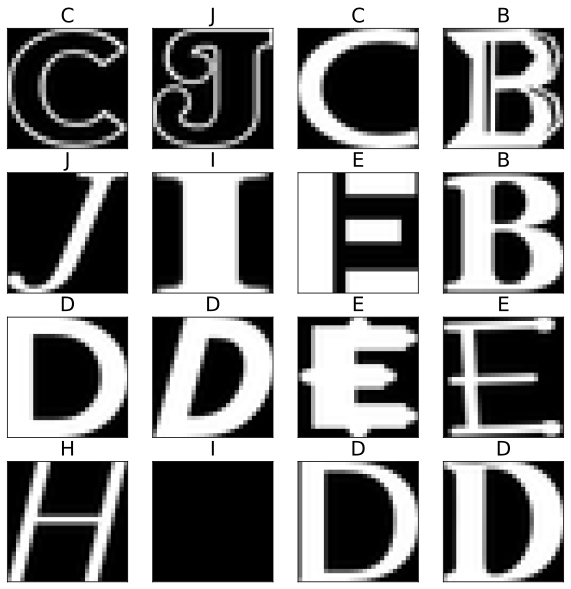

In [7]:
plot_letters(X_train, y_train, random_state=912)

## Naive Bayes

In [ ]:
%%time
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

optNB = GaussianNB(var_smoothing=1e-07)
optNB.fit(X_train, y_train)


Test Accuracy: 0.7975


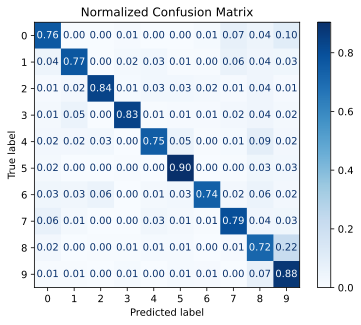

In [16]:
y_pred = optNB.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred, normalize='true')

display_labels = np.unique(y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title("Normalized Confusion Matrix")
plt.show()

## Decision tree

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a pipeline (optional for Decision Trees, but useful if adding preprocessing steps)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional for Decision Trees
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Define parameter grid for Decision Tree
param_grid = {
    'dt__max_depth': [None, 10, 20, 30, 40, 50],
    'dt__min_samples_split': [2, 5, 10, 15],
    'dt__min_samples_leaf': [1, 2, 4, 6],
    'dt__criterion': ['gini', 'entropy']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best estimator
best_model = grid_search.best_estimator_

# Predict on test set
y_pred_best = best_model.predict(X_test)

# Evaluate the tuned model
print("\nTuned Decision Tree Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
conf_mat_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Decision Tree')
plt.show()

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=2; total time=   6.7s
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=10; total time=   7.9s
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=1, dt__min_samples_split=15; total time=  13.1s
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=5; total time=  10.1s
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=2, dt__min_samples_split=15; total time=   9.0s
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=4, dt__min_samples_split=5; total time=   8.2s
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=4, dt__min_samples_split=10; total time=   8.5s
[CV] END dt__criterion=gini, dt__max_depth=None, dt__min_samples_leaf=6, dt__min_samples_split=2; total time=   7.

NameError: name 'digits' is not defined

<Figure size 1000x800 with 0 Axes>

In [17]:
dt_best_model = best_model
dt_y_pred = dt_best_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, dt_y_pred):.4f}")

Accuracy: 0.8223


## Random Forest

## MLP

## CNN

## Plot results